In [1]:
import logging
import math 

import numpy as np
import pandas as pd
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset

!pip install -q pytorch-lightning pytorch-lightning-bolts
import pytorch_lightning as pl

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 708 kB 5.3 MB/s 
     |████████████████████████████████| 252 kB 50.1 MB/s 
     |████████████████████████████████| 529 kB 47.5 MB/s 


In [ ]:
# For the full MSLR-WEB30k dataset with 30k queries
# Docs: https://www.tensorflow.org/datasets/catalog/mslr_web
# import tensorflow_datasets as tfds

# ds = tfds.load("mslr_web/30k_fold1")
# test_df = tfds.as_dataframe(ds["test"])
# train_df = tfds.as_dataframe(ds["train"])

# Alternative without TensorFlow: https://akshay-a-kulkarni.github.io/ltr/#21-downloading-unzipping

In [2]:
!pip install -q catboost 
from catboost.datasets import msrank 

# Subset of the full MSLR-WEB30k dataset that contains 
# 6k (train) and 4k (test) queries with typically ~100 items
# per query
train_df, test_df = msrank()

X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values


train_df.head()

     |████████████████████████████████| 76.8 MB 1.2 MB/s 


,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,1.0,3.0,3.0,0.0,0.0,3.0,1.0,1.0,0.0,...,62.0,11089534.0,2.0,116.0,64034.0,13.0,3.0,0.0,0.0,0.0
1,0.0,1.0,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,44.0,5.0,30.0,23836.0,63634.0,2.0,4.0,0.0,0.0,0.0
2,0.0,1.0,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,59.0,5.0,8.0,213.0,48469.0,1.0,13.0,0.0,0.0,0.0
3,0.0,1.0,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,44.0,0.0,30.0,23871.0,63634.0,3.0,4.0,0.0,0.0,0.0
4,0.0,1.0,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,44.0,4.0,30.0,23848.0,63634.0,3.0,4.0,0.0,0.0,0.0


## EDA

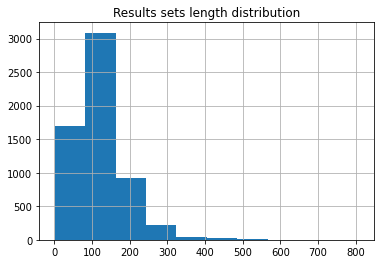

In [ ]:
ax = train_df[1].value_counts().hist()
ax.set_title("Results sets length distribution");

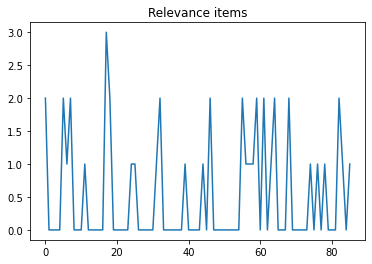

In [ ]:
first_query = train_df[train_df[1] == 1]
ax = first_query[0].plot()
ax.set_title("Relevance items");

In [ ]:
train_df.shape

(723412, 138)

## Data preparation

In [3]:
x_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values

# Simple standardization
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
mu = x_train.mean(dim=[0])
sigma = x_train.std(dim=[0])
x_train = (x_train - mu) / sigma
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

x_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values

x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
x_test = (x_test - mu) / sigma
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Note that further "custom" preprocessing can be applied following the AllRank repo:
# https://github.com/allegro/allRank/blob/master/reproducibility/normalize_features.py

In [9]:
max_length = 50

class RankingDataset(Dataset):
    def __init__(self, features, labels, query_ids, max_length=max_length):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.query_ids = torch.tensor(query_ids, dtype=torch.float32)
        self.unique_queries = np.unique(query_ids)
        self.max_length = max_length

    def __len__(self) -> int:
        """In PyTorch datasets have to override the length method."""
        return len(self.unique_queries)

    def __getitem__(self, index: int) -> dict:
        """This method defines how to feed the data during model training."""
        mask = (self.query_ids == self.unique_queries[index])
        
        x = self.features[mask][:self.max_length]
        y = self.labels[mask][:self.max_length]
        
        # Padding 
        pad_length = self.max_length - len(y)
        if pad_length > 0:
            x = nn.functional.pad(x, (0, 0, 0, pad_length)) 
            y = nn.functional.pad(y, (0, pad_length), value=0) # Q: shall I pad with -infinity?
        return x, y 

# Shape of model input has to match: 
# (batch_size, sequence_length, embedding_dimension)        
train_dataset = RankingDataset(x_train, y_train, queries_train)
train_dataloader = DataLoader(train_dataset, batch_size=50)

print(f"First sample: {train_dataset[0]}")

test_dataset = RankingDataset(x_test, y_test, queries_test)
test_dataloader = DataLoader(test_dataset, batch_size=50)

First sample: (tensor([[ 0.8615,  4.8647, -1.1421,  ..., -0.0073, -0.0237, -0.0053],
        [ 0.8615, -0.3591,  1.7981,  ..., -0.0073, -0.0237, -0.0053],
        [ 0.8615, -0.3591,  1.7981,  ..., -0.0073, -0.0237, -0.0053],
        ...,
        [-1.4720, -0.3591, -1.1421,  ..., -0.0073, -0.0237, -0.0053],
        [ 0.8615, -0.3591,  0.8180,  ..., -0.0073, -0.0237, -0.0053],
        [ 0.8615, -0.3591,  1.7981,  ..., -0.0073, -0.0237, -0.0053]],
       device='cuda:0'), tensor([2., 0., 0., 0., 0., 2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3.,
        2., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0.],
       device='cuda:0'))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# Modeling

In [5]:
def ndcg_pytorch(scores, relevances, k=None, exclude_irrelevant_queries=False):
    """Compute the Normalized Discounted Cumulative Gain (NDCG) for a batch of queries 
    with PyTorch scores and corresponding relevances.

    Queries with no relevant items (relevances all zero) can either be counted as ones 
    in the NDCG calculation, or excluded from the average.

    Examples
    --------
    >>> scores = torch.tensor(
    ...     [[0.3739, -0.5981, -0.0843], [0.0663, -0.1290,  0.4428]], device=device
    ... )
    >>> relevances = torch.tensor([[1, 2, 0], [0, 0,  0]], device=device)
    >>> ndcg_pytorch(scores, relevances).cpu()
    tensor(0.8801)
    """
    def compute_dcg(scores, relevances, k):        
        predicted_rankings = torch.argsort(scores, dim=1, descending=True)

        if k is not None:
            predicted_rankings = predicted_rankings[:, :k]
        discounts = torch.log2(torch.arange(2, predicted_rankings.shape[1]+2)).to(device)
        ranking_relevances = torch.gather(relevances, 1, predicted_rankings)
        dcg = (ranking_relevances / discounts).sum(dim=1)
        return dcg

    dcg = compute_dcg(scores, relevances, k)
    idcg = compute_dcg(relevances, relevances, k)
    
    if exclude_irrelevant_queries:
        ndcg = (dcg / idcg).nanmean()
    else:
        ndcg = torch.ones_like(dcg)
        mask = (idcg > 0)
        ndcg[mask] = dcg[mask] / idcg[mask]
        ndcg = ndcg.mean()

    return ndcg


def relevance_mse(predictions, relevances):
    """

    Parameters
    ----------
    predictions: np.array of floats of shape (batch_size, sequence_length) 
    relevances: np.array of shape (batch_size, sequence_length) 

    Returns
    -------
    float: 

    Examples
    --------
    >>> predictions = torch.FloatTensor([[1, 2, 3], [1, 3, 2]])
    >>> relevances = torch.LongTensor([[0, 1, 1], [1, 0, 0]])
    >>> relevance_mse(predictions, relevances)
    tensor(3.1667)
    """       
    return nn.MSELoss()(predictions, relevances).sum()

# import doctest; doctest.testmod() # Uncomment to run the doctests

## Baseline: pointwise MLP

In [ ]:
class LightningPointwiseRanker(pl.LightningModule):
    def __init__(self, input_dimension=X_train.shape[1], output_dimension=1):
        super().__init__()
        self.linear = nn.Linear(input_dimension, output_dimension)
        self.criterion = nn.MSELoss()

        self.model = nn.Sequential(
            nn.Linear(input_dimension, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(128, output_dimension),
        )
  

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        
        x = x.flatten(end_dim=1)
        y = y.flatten()

        outputs = self.forward(x)[:, 0]
        loss = self.criterion(outputs, y)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.training_step(batch, batch_idx)
        self.log('val_loss', loss)
        
        x, y = batch
        outputs = self.forward(x).reshape(y.shape[0], y.shape[1])
        ndcg = ndcg_pytorch(outputs, y, k=5)
        self.log("NDCG@5", ndcg)

        batch_length = outputs.shape[0]
        seq_length = outputs.shape[1]
        scores = torch.arange(seq_length, 0, -1).repeat(batch_length, 1).to(device)
        ndcg_dataset = ndcg_pytorch(scores, y, k=5)
        self.log("NDCG@5 data", ndcg_dataset)

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

lightning_pointwise_ranker = LightningPointwiseRanker()
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=1, log_every_n_steps=10)

trainer.test(lightning_pointwise_ranker, train_dataloader)
trainer.test(lightning_pointwise_ranker, test_dataloader)

trainer.fit(lightning_pointwise_ranker, train_dataloader, test_dataloader)

trainer.test(lightning_pointwise_ranker, train_dataloader)
trainer.test(lightning_pointwise_ranker, test_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.3146687150001526
       NDCG@5 data           0.305801123380661
        val_loss            1.0365898609161377
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5              0.316812127828598
       NDCG@5 data          0.31024664640426636
        val_loss            1.0836939811706543
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.42594876885414124
       NDCG@5 data           0.305801123380661
        val_loss            0.5976350903511047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.43506476283073425
       NDCG@5 data          0.31024664640426636
        val_loss            0.6254591941833496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.6254591941833496,
  'NDCG@5': 0.43506476283073425,
  'NDCG@5 data': 0.31024664640426636}]

## SOTA: Context-Aware Learning to Rank with Self-Attention

📄 Paper: https://arxiv.org/pdf/2005.10084.pdf

🐙 Code: https://github.com/allegro/allRank/


In [14]:
class LightningTransformer(pl.LightningModule):
    def __init__(self, model, objective_function=relevance_mse, learning_rate=1e-3):
        super().__init__()

        self.objective_function = objective_function
        self.learning_rate = learning_rate
        
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self.forward(x)
        loss = self.objective_function(outputs, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self.forward(x)
        loss = self.objective_function(outputs, y)
        self.log('val_loss', loss, prog_bar=True)
                
        ndcg = ndcg_pytorch(outputs, y, k=5)
        self.log("NDCG@5", ndcg, prog_bar=True)

        batch_length = outputs.shape[0]
        seq_length = outputs.shape[1]
        scores = torch.arange(seq_length, 0, -1).repeat(batch_length, 1).to(device)
        ndcg_dataset = ndcg_pytorch(scores, y, k=5)
        self.log("NDCG@5 data", ndcg_dataset, prog_bar=True)
        return loss


    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


input_dimension = X_train.shape[1]
embedding_dimension = 128

embedding_layer = nn.Linear(input_dimension, embedding_dimension)
encoder_layer = nn.TransformerEncoderLayer(
    d_model=embedding_dimension,
    nhead=4,
    dim_feedforward=512,
    dropout=0.4,
    batch_first=False
)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
output_layer = nn.Linear(embedding_dimension, 1)
flattening_layer = nn.Flatten(start_dim=1)

model = nn.Sequential(
    embedding_layer,
    transformer_encoder,
    output_layer,
    flattening_layer
)


lightning_transformer = LightningTransformer(model).to(device)
trainer = pl.Trainer(
    accelerator='gpu', devices=1, max_epochs=3, check_val_every_n_epoch=1
)

trainer.test(lightning_transformer, train_dataloader)
trainer.test(lightning_transformer, test_dataloader)

trainer.fit(lightning_transformer, train_dataloader, test_dataloader)

trainer.test(lightning_transformer, train_dataloader)
trainer.test(lightning_transformer, test_dataloader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5              0.275585412979126
       NDCG@5 data           0.305801123380661
        val_loss            1.0448641777038574
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.2832064628601074
       NDCG@5 data          0.31024664640426636
        val_loss            1.0582183599472046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.5130599737167358
       NDCG@5 data           0.305801123380661
        val_loss            0.5473312139511108
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.5177253484725952
       NDCG@5 data          0.31024664640426636
        val_loss            0.5673443078994751
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.5673443078994751,
  'NDCG@5': 0.5177253484725952,
  'NDCG@5 data': 0.31024664640426636}]

## Transformer: Top-1 probability prediction

End goal is to directly maximize the expectd NDCG 

$$
\mathbb E [NDCG(p_r)]=\sum_r \frac1{\log_2(r+1)}\sum_i p_r(i)\mathrm{rel}_i
$$
where $\mathrm{rel}_i$ is the relevance of item $i$.

We start with the NDCG@1: $\mathbb E [NDCG@1(p_1)]=\sum_i p_1(i)\mathrm{rel}_i$

In [15]:
softmax = nn.Softmax(dim=1)

def expected_relevance(predictions, relevances):
    """Expected relevance objective, the optimal value is 0 (when the predicted 
    probabilities follow the distribution wih maximum expected relevance).

    Parameters
    ----------
    predictions: torch.tensor of floats of shape (batch_size, sequence_length) 
    relevances: torch.tensor of shape (batch_size, sequence_length) 

    Returns
    -------
    float: 

    Examples
    --------
    >>> predictions = torch.FloatTensor([[1, 2, 3], [1, 3, 2]])
    >>> relevances = torch.LongTensor([[0, 1, 1], [1, 0, 0]])
    >>> expected_relevance(predictions, relevances)
    tensor(0.5000)
    """
    max_relevance = relevances.max(dim=1).values
    scores = softmax(predictions)
    expected_relevance = max_relevance - torch.sum(scores*relevances, dim=1)
    return expected_relevance.mean()


In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = max_length):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [16]:
lightning_transformer = LightningTransformer(
    model,
    objective_function=expected_relevance,
    learning_rate=1e-4
).to(device)

trainer = pl.Trainer(
    accelerator='gpu', devices=1, max_epochs=20, check_val_every_n_epoch=1
)

trainer.test(lightning_transformer, train_dataloader)
trainer.test(lightning_transformer, test_dataloader)

trainer.fit(lightning_transformer, train_dataloader, test_dataloader)

trainer.test(lightning_transformer, train_dataloader)
trainer.test(lightning_transformer, test_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.5130599737167358
       NDCG@5 data           0.305801123380661
        val_loss            1.8464614152908325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.5177253484725952
       NDCG@5 data          0.31024664640426636
        val_loss            1.8554266691207886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.5407206416130066
       NDCG@5 data           0.305801123380661
        val_loss             1.087185263633728
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         NDCG@5             0.5221924185752869
       NDCG@5 data          0.31024664640426636
        val_loss            1.2144606113433838
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.2144606113433838,
  'NDCG@5': 0.5221924185752869,
  'NDCG@5 data': 0.31024664640426636}]

In [17]:
# Check an individual sample
data = iter(train_dataloader)
next(data)
sample = next(data)
x = sample[0].to(device)
y = sample[1]

scores = lightning_transformer.to(device).forward(x)[0]

print("Search scores")
print(scores.sort(descending=True)[0])
print("-"*88)

print("Labels")
print(y[0])
print("-"*88)

print("Relevances predicted optimal order")
print(y[0][scores.sort(descending=True).indices])
print("-"*88)

query_ndcg = ndcg_pytorch(lightning_transformer.to(device).forward(x), y, k=5).item()
print(f"Query NDCG: {query_ndcg:.4f}")

Search scores
tensor([  0.1152,  -6.6013,  -6.6073,  -9.0911,  -9.5903,  -9.7382, -10.3125,
        -10.3148, -10.3306, -10.9070, -10.9706, -11.0809, -11.5815, -11.5839,
        -11.8245, -12.1961, -12.2508, -12.3481, -12.3597, -12.5111, -12.6292,
        -12.7708, -12.7725, -12.8221, -12.8301, -13.1080, -13.3244, -13.3315,
        -13.5606, -13.5653, -13.5783, -13.5886, -13.6878, -13.7800, -13.8930,
        -13.8956, -13.9363, -13.9458, -14.0022, -14.0216, -14.1012, -14.1313,
        -14.1583, -14.1856, -14.2162, -14.2681, -14.3115, -14.3848, -14.7187,
        -15.0252], device='cuda:0', grad_fn=<SortBackward0>)
----------------------------------------------------------------------------------------
Labels
tensor([0., 0., 1., 2., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2., 1., 1.,
        0., 0., 1., 2., 2., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 0., 1., 2., 0., 0., 1., 0., 0., 1., 0., 2., 1.],
       device='cuda:0')
----------------------------------